In [3]:
from imutils import face_utils
import dlib
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import copy
from sklearn.metrics import mean_squared_error

Задание №1
Базовая работа с python/numpy

In [4]:
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

cap = cv2.VideoCapture(0)
path_img='./img_face/*.jpg'
def show_detect_face(img):
    plt.imshow(img)
    plt.show()

IMAGE_FILES = glob.glob(path_img)
def detect_point(image):


    rects = detector(image, 0)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)
        return shape, rect


def draw_point(image, shape, size_point=7,color=(0, 255, 0), rect=None):
    for (x, y) in shape:
        cv2.circle(image, (x, y), size_point, color, -1)
        if rect is not None:
            cv2.rectangle(image, (rect.right(), rect.top()), (rect.left(), rect.bottom()), (255, 25, 0), 6)
    return image


def detect_face(image):
    shape, rect=detect_point(image)
    image=draw_point(image, shape, rect=rect)
    show_detect_face(image)


def recove_img_data(data, index, reshape_w, reshape_h):

    img = data.iloc[index].Image
    img = list(map(lambda x:int(x),img.split(' ')))
    img = np.array(img).reshape(reshape_h, reshape_w)
    return img

def closest_node(points, point, name, size_w=1, size_h=1):
    dist=99999999999
    corr_id=0
    for id, point_0 in enumerate(points):
        if dist> math.hypot(point_0[0] - point[0], point_0[1] - point[1]):
            dist=math.hypot(point_0[0] - point[0], point_0[1] - point[1])
            corr_id=id
    return corr_id, dist

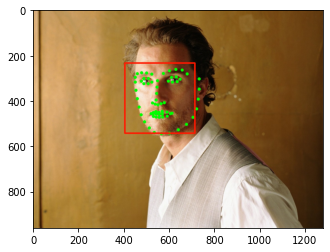

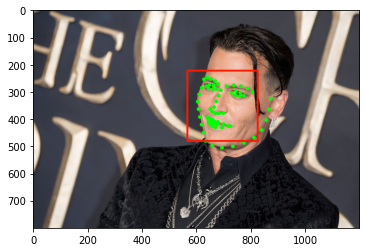

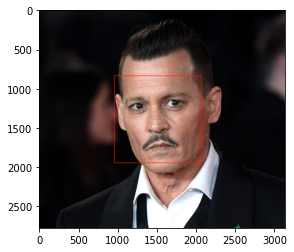

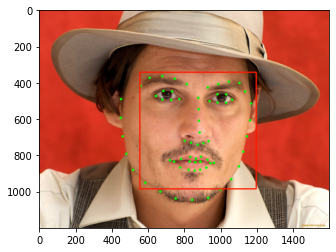

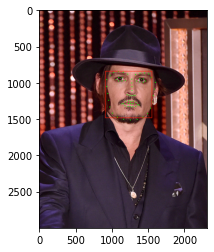

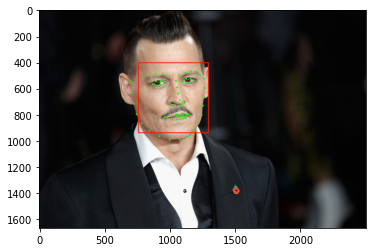

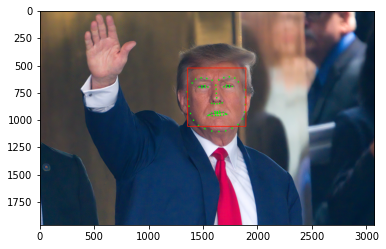

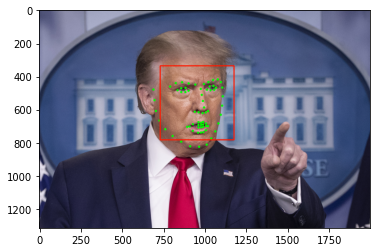

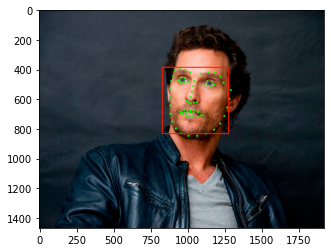

In [10]:
#detect_face_img()
for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detect_face(img_rgb)

Задание №2
1. Скачал датасет, очистил данные от nan и сохранил в новый файл train_15.csv
2. Нашел из 68 точек 15 точек, которые соответствуют точкам в датасете. Соответствие находил через функцию closest_node. Индексы для каждой позиции сохраняются в result_index.

In [18]:
size_h=96
size_w=96
path_csv='./csv/train_15.csv'
data_csv_train=pd.read_csv(path_csv)
columns=data_csv_train.columns
filter_columns=[]
for column in range(1,len(columns)-1,2):
    filter_columns.append(columns[column][0:-2])
point_dict=dict.fromkeys(range(68), 0)

frecuence_point={}
n=500
for i in filter_columns:
    frecuence_point[i]=copy.deepcopy(point_dict)
for i in range(n):
    img = recove_img_data(data_csv_train, i, size_w, size_h)
    img_ = np.uint8(img)
    try:
        shape, _, = detect_point(img_)
    except TypeError:
        continue
    for cowl in range(1,len(columns)-1,2):
        points=(data_csv_train.iloc[i][columns[cowl]], data_csv_train.iloc[i][columns[cowl+1]])
        id_shape, _ = closest_node(shape, points, columns[cowl], size_w, size_h)
        frecuence_point[columns[cowl][0:-2]][id_shape]+=1
result_index={}
result_r2_score={}
points_predict={}
points_dataset={}
for f in frecuence_point:
    print(f"max_{f}={max(frecuence_point[f], key=frecuence_point[f].get)}")
    result_index[f]=max(frecuence_point[f], key=frecuence_point[f].get)
    result_r2_score[f]={'x':[], 'y':[] }
    points_predict[f]={'x':[], 'y':[] }
    points_dataset[f] = {'x': [], 'y': []}

max_left_eye_center=44
max_right_eye_center=40
max_left_eye_inner_corner=42
max_left_eye_outer_corner=45
max_right_eye_inner_corner=39
max_right_eye_outer_corner=36
max_left_eyebrow_inner_end=22
max_left_eyebrow_outer_end=26
max_right_eyebrow_inner_end=21
max_right_eyebrow_outer_end=17
max_nose_tip=30
max_mouth_left_corner=54
max_mouth_right_corner=48
max_mouth_center_top_lip=51
max_mouth_center_bottom_lip=57


3. Ниже отобрано и визуализировано 5 изображений с лучшим результатом и 4 с худшим. Оценка производилась за счет среднеквадратичной ошибки по каждой из осей x,y. Метрику я выбрал на основании предположения, что сильных выбросов ошибок на алгоритме библиотеки dlib быть не должно. Также я проверил данные по метрике R2, но по параметру max_right_eye_inner_corner был получен неадекватный результат из-за малого значения SST в знаменателе.
-Ground Truth зеленый пиксель,
-Predicts-синий пиксель

cool, mean_squared_error=1.4413131960500065


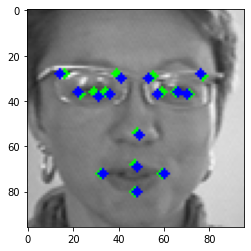

cool, mean_squared_error=1.518225225743926


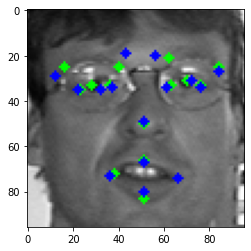

cool, mean_squared_error=1.5242634236446477


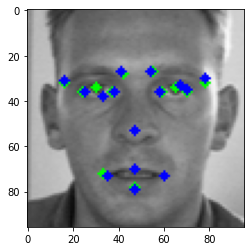

cool, mean_squared_error=1.6839403563301398


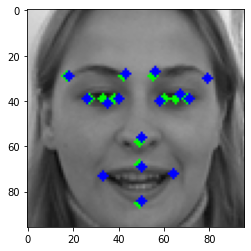

cool, mean_squared_error=1.7577496139001982


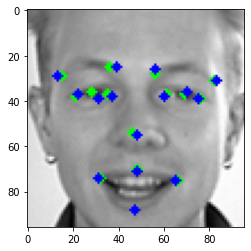

bad, mean_squared_error=5.885356176293889


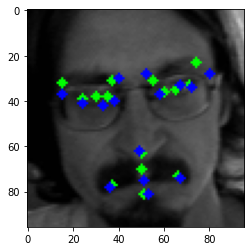

bad, mean_squared_error=6.966634205635775


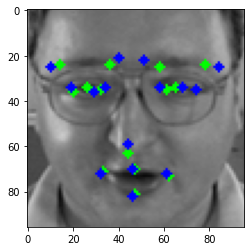

bad, mean_squared_error=10.193310995202626


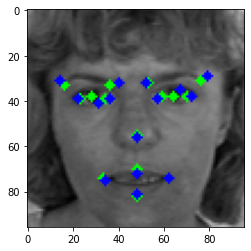

bad, mean_squared_error=11.351713355016923


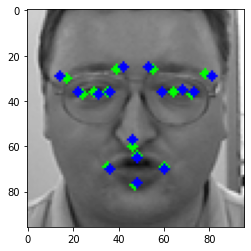

In [19]:
collect=[]
for i in range(100):
    img = recove_img_data(data_csv_train, i, size_w, size_h)
    img_ = np.uint8(img)
    try:
        shape, _, = detect_point(img_)
    except TypeError:
        continue
    points_dataset_x=[]
    points_dataset_y=[]

    points_pred_x=[]
    points_pred_y=[]

    for cowl in range(1,len(columns)-1,2):
        points_dataset_x.append(data_csv_train.iloc[i][columns[cowl]])
        points_dataset_y.append(data_csv_train.iloc[i][columns[cowl+1]])

        points_pred_x.append(shape[result_index[columns[cowl][0:-2]]][0])
        points_pred_y.append(shape[result_index[columns[cowl][0:-2]]][1])

    sq_x = mean_squared_error(points_dataset_x, points_pred_x)
    sq_y = mean_squared_error(points_dataset_y, points_pred_y)
    collect.append((sq_x+sq_y)/2)


collect_i=sorted(range(len(collect)), key=lambda k: collect[k])
collect_i_cool=collect_i[0:5]
collect_i_bad=collect_i[-6:-1]

for i in collect_i_cool:
    img = recove_img_data(data_csv_train, i, size_w, size_h)
    img_ = np.uint8(img)
    point_pred = []
    points_data = []
    try:
        shape, _, = detect_point(img_)
    except TypeError:
        continue
    for cowl in range(1,len(columns)-1,2):
        points_data.append((int(data_csv_train.iloc[i][columns[cowl]]), int(data_csv_train.iloc[i][columns[cowl+1]])))
        point_pred.append((shape[result_index[columns[cowl][0:-2]]][0], shape[result_index[columns[cowl][0:-2]]][1]))
    print(f"cool, mean_squared_error={collect[i]}")
    show_detect_face(draw_point(draw_point(cv2.cvtColor(img_,  cv2.COLOR_GRAY2RGB), points_data, size_point=2), point_pred, size_point=2, color=(0,0,255)))


for i in collect_i_bad:
    img = recove_img_data(data_csv_train, i, size_w, size_h)
    img_ = np.uint8(img)
    point_pred = []
    points_data = []
    try:
        shape, _, = detect_point(img_)
    except TypeError:
        continue
    for cowl in range(1,len(columns)-1,2):
        points_data.append((int(data_csv_train.iloc[i][columns[cowl]]), int(data_csv_train.iloc[i][columns[cowl+1]])))
        point_pred.append((shape[result_index[columns[cowl][0:-2]]][0], shape[result_index[columns[cowl][0:-2]]][1]))
    print(f"bad, mean_squared_error={collect[i]}")
    show_detect_face(draw_point(draw_point(cv2.cvtColor(img_,  cv2.COLOR_GRAY2RGB), points_data, size_point=2), point_pred, size_point=2, color=(0,0,255)))


Я провел оценку по метрике MSE для каждой зоны лица и построил диаграмму. Из диаграммы видно, что самое сильное отклонение было для left_eyebrow_inner_end, по оси "x" она составила 12.9 пикселей, по оси "y" - 4.7 пикселей.

In [13]:
for i in range(n):
    img = recove_img_data(data_csv_train, i, size_w, size_h)
    img_ = np.uint8(img)
    try:
        shape, _, = detect_point(img_)
    except TypeError:
        continue
    for cowl in range(1, len(columns) - 1, 2):
        points_dataset[columns[cowl][0:-2]]['x'].append(data_csv_train.iloc[i][columns[cowl]])
        points_dataset[columns[cowl][0:-2]]['y'].append(data_csv_train.iloc[i][columns[cowl+1]])

        points_predict[columns[cowl][0:-2]]['x'].append(shape[result_index[columns[cowl][0:-2]]][0])
        points_predict[columns[cowl][0:-2]]['y'].append(shape[result_index[columns[cowl][0:-2]]][1])
for i in result_r2_score:
    result_r2_score[i]['x']=mean_squared_error(points_dataset[i]['x'], points_predict[i]['x'])
    result_r2_score[i]['y'] = mean_squared_error(points_dataset[i]['y'], points_predict[i]['y'])
    print(f"result_r2_score={i}_X={result_r2_score[i]['x']}  result_r2_score={i}_Y={result_r2_score[i]['y']} ")

result_r2_score=left_eye_center_X=7.111584132715651  result_r2_score=left_eye_center_Y=6.411213275691553 
result_r2_score=right_eye_center_X=4.460443295373387  result_r2_score=right_eye_center_Y=7.154894399065894 
result_r2_score=left_eye_inner_corner_X=3.2226227485753824  result_r2_score=left_eye_inner_corner_Y=0.23120824866267475 
result_r2_score=left_eye_outer_corner_X=0.374725660422229  result_r2_score=left_eye_outer_corner_Y=1.1689142112733246 
result_r2_score=right_eye_inner_corner_X=0.6715663491501946  result_r2_score=right_eye_inner_corner_Y=0.19058982003549516 
result_r2_score=right_eye_outer_corner_X=0.5448998221967287  result_r2_score=right_eye_outer_corner_Y=0.7057927015835276 
result_r2_score=left_eyebrow_inner_end_X=12.924042314638001  result_r2_score=left_eyebrow_inner_end_Y=4.784333165212551 
result_r2_score=left_eyebrow_outer_end_X=4.10890530241104  result_r2_score=left_eyebrow_outer_end_Y=7.468324273751156 
result_r2_score=right_eyebrow_inner_end_X=2.144473847089815  

Text(0.5, 1.0, 'Средняя квадратичная ошибка в пикселях\n')

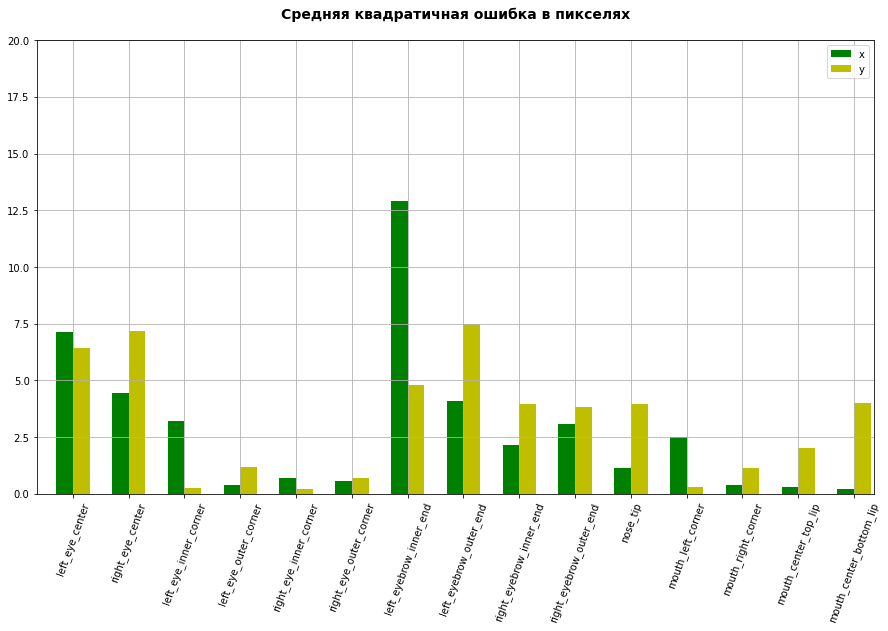

In [14]:
# #########################plot##################################################
# ###столбчатая диаграмма r2_score по каждому классу
color={'x': 'g', 'y':'y'}
plt.figure(figsize=(15,10))
plt.axis([0,15,0,20])
index = np.arange(15)
bw = 0.3
plt.grid()
plt.xticks(index+0.65,list(result_r2_score.keys()), rotation=70)
plt.subplots_adjust(bottom=0.25)
x = [result_r2_score[feature]['x'] for feature in result_r2_score]
y = [result_r2_score[feature]['y'] for feature in result_r2_score]
plt.bar(index+0.5, x, bw, color='g')
plt.bar(index+0.8, y, bw, color='y')
plt.legend (('x', 'y'))
plt.title('Средняя квадратичная ошибка в пикселях\n',
                fontsize = 14, fontweight ='bold')

Задание №3
Зарегистрировался на сервисе, ознакомился с API. Через скрипт создал проект, загрузил туда изображения и разметку в виде набора точек. Однако при загрузке изображения из датасета размером 96*96 точки для разметки имели слишком большой размер, а уменьшить их через предложенные методы (resize, scale) не удалось. Поэтому я загрузил другое изображение с большим разрешением и разметкой в виде точек. Скриншот лежит в папке result_sv.

Также я опробовал алгоритм из библиотеки mediapipe для генерации трехмерной маски с 468 точками.

In [6]:
import mediapipe as mp

In [11]:

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
detector = mp.solutions.face_detection
fd=detector.FaceDetection(min_detection_confidence=0.6)

def detect_face_mp():
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
      for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
          continue
        annotated_image = image.copy()
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_TESSELATION,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_tesselation_style())
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_CONTOURS,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_contours_style())
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_iris_connections_style())

            h, w, c = image.shape
            cx_min = w
            cy_min = h
            cx_max = cy_max = 0
            for id, lm in enumerate(face_landmarks.landmark):
                cx, cy = int(lm.x * w), int(lm.y * h)
                if cx < cx_min:
                    cx_min = cx
                if cy < cy_min:
                    cy_min = cy
                if cx > cx_max:
                    cx_max = cx
                if cy > cy_max:
                    cy_max = cy
            cv2.rectangle(annotated_image, (cx_min, cy_min), (cx_max, cy_max), (255, 255, 0), 2)
        show_detect_face(cv2.cvtColor(annotated_image,  cv2.COLOR_BGR2RGB))

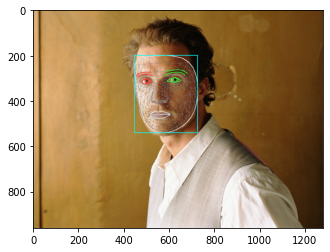

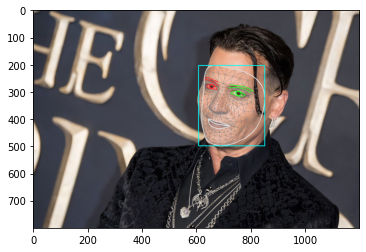

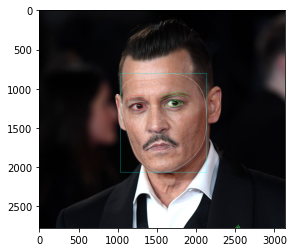

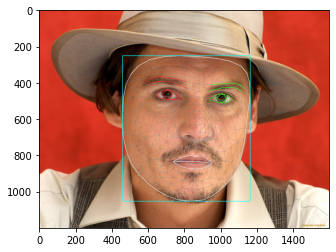

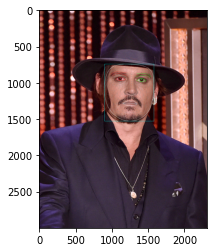

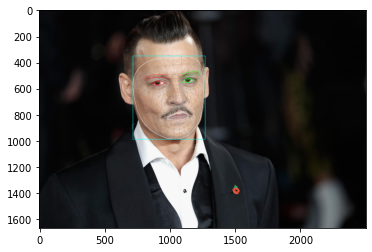

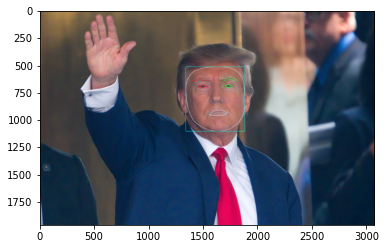

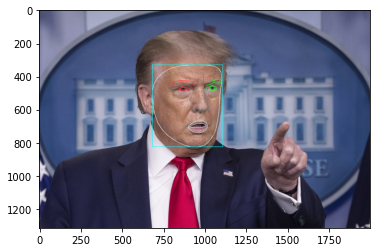

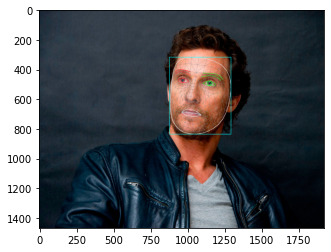

In [12]:
detect_face_mp()